In [1]:
import yaml
import healpy as hp
import numpy as np
import os
import scipy

from plancklens import utils

from jointmap.plots import CMBLensingPlot 

from delensalot.core import cachers

import os
import numpy as np

from delensalot.core.iterator import statics

import yaml

import matplotlib.pyplot as plt



mpisupport: False, pmisupport: False
disabling mpi
Using lenspyx alm2map


In [2]:
def bin_theory(cl, bin_edges):
    l = np.arange(len(cl))
    sums = scipy.stats.binned_statistic(l, l, statistic="sum", bins=bin_edges)
    cl = scipy.stats.binned_statistic(l, l*cl, statistic="sum", bins=bin_edges)
    cl = cl[0] / sums[0]
    el = (bin_edges[1:] + bin_edges[:-1])/2
    return el, cl


bin_edges = np.arange(10, 4000, 20)


def cross_corr_coeff(a, b, base=0, color=None, plot=True, ax=None, label=None):
    ls = np.arange(len(hp.alm2cl(a)))
    decorator = lambda x: bin_theory(x, bin_edges)
    el, x = decorator(hp.alm2cl(a, b))
    el, aa = decorator(hp.alm2cl(a, a))
    el, bb = decorator(hp.alm2cl(b, b))
    xcorr = np.sqrt(x**2 / (aa * bb))
    if plot and ax is not None:
        ax.plot(el, xcorr - base, color=color, label=label)
    return el, xcorr


def cross_corr_coeff_from_cl(a, b, x, base=0, color=None, plot=True, ax=None, label=None):
    ls = np.arange(len(a))
    decorator = lambda x: bin_theory(x, bin_edges)
    el, x = decorator(x)
    el, aa = decorator(a)
    el, bb = decorator(b)
    xcorr = np.sqrt(x**2 / (aa * bb))
    if plot and ax is not None:
        ax.plot(el, xcorr - base, color=color, label=label)
    return el, xcorr

In [3]:
def load_config(file_path):
    with open(file_path, 'r') as file:
        return yaml.safe_load(file)
    

def load_inputs(config, selected, scratch, cmbversion, lmax_rec, simidx = 0):
    #input_names = {"p": f"sim_{simidx:04}_plm", "o": f"sim_{simidx:04}_olm", "f": f"sim_{simidx:04}_tau_lm", "a": f"sim_{simidx:04}_alpha_lm"}
    input_names = {"p": f"sim_{simidx:04}_plm", "o": f"sim_{simidx:04}_alpha_lm", "f": f"sim_{simidx:04}_tau_lm", "a": f"sim_{simidx:04}_alpha_lm"}
    inputs = {}
    print("Inputs in", f"{scratch}/{cmbversion}")
    for k in selected:
        input = hp.read_alm(f"{scratch}/{cmbversion}/simswalpha/{input_names[k]}.fits")
        inputs[k] = utils.alm_copy(input, lmax=lmax_rec)
    return inputs


# Function to process a configuration and prepare data for plotting
def process_config(config_path, itrs, subset_selected, simidx = 0):
    config = load_config(config_path)
    scratch = os.getenv("SCRATCH") + "/JOINTRECONSTRUCTION/"
    cmbversion = config["cmb_version"]
    version = config["v"]
    imin = config["imin"]
    simidx = imin
    qe_key = config["k"]
    its_folder = f"{scratch}/{cmbversion}_version_{version}_recs/{qe_key}_sim{simidx:04}{version}/"
    print("Reading from", its_folder)
    recs = statics.rec()
    plms = recs.load_plms(its_folder, itrs=itrs)

    Nselected = len(config["selected"])
    lmax_rec = hp.Alm.getlmax(np.split(plms[0], Nselected)[0].shape[0])
    selected = list(map(lambda s: s[0] if len(s) == 2 else s, config["selected"]))
    subset_selected = [k for k in subset_selected if k in selected]
    inputs = load_inputs(config, selected, scratch, cmbversion, lmax_rec, simidx)
    title = config.get("title", f"Config: {os.path.basename(config_path)}")
    return selected, subset_selected, plms, inputs, lmax_rec, title

In [4]:
def process_config_npy(config_path):

    config = load_config(config_path)
    scratch = os.getenv("SCRATCH") + "/joint_map_outputs/"
    cmbversion = config["cmb_version"]
    version = config["v"]
    imin, imax = config["imin"], config["imax"]
    itmax = config["itmax"]
    qe_key = config["k"]

    its_file = f"{scratch}/total_qe_it_{qe_key}_{version}_{cmbversion}_{imin}_{imax}_{itmax}.npy"
    autoits = np.load(its_file)

    its_file = f"{scratch}/total_qe_it_cross_{qe_key}_{version}_{cmbversion}_{imin}_{imax}_{itmax}.npy"
    crossits = np.load(its_file)

    its_file = f"{scratch}/total_qe_it_cross_down_{qe_key}_{version}_{cmbversion}_{imin}_{imax}_{itmax}.npy"
    if os.path.exists(its_file):
        crossits_down = np.load(its_file)
    else:
        crossits_down = 0

    its_file = f"{scratch}/input_{version}_{cmbversion}_{imin}_{imax}_{itmax}.npy"
    auto_input_its = np.load(its_file)

    its_file = f"{scratch}/input_down_{version}_{cmbversion}_{imin}_{imax}_{itmax}.npy"
    if os.path.exists(its_file):
        auto_input_down_its = np.load(its_file)
    else:
        auto_input_down_its = 0


    selected = list(map(lambda s: s[0] if len(s) == 2 else s, config["selected"]))
    
    return selected, autoits, crossits, auto_input_its, crossits_down, auto_input_down_its



In [5]:
def process_config(config_path, itrs, subset_selected, simidx = 0):
    config = load_config(config_path)
    scratch = os.getenv("SCRATCH") + "/JOINTRECONSTRUCTION/"
    cmbversion = config["cmb_version"]
    version = config["v"]
    simidx = config["imin"]
    qe_key = config["k"]
    its_folder = f"{scratch}/{cmbversion}_version_{version}_recs/{qe_key}_sim{simidx:04}{version}/"

    print("Reading from", its_folder)

    recs = statics.rec()
    plms = recs.load_plms(its_folder, itrs=itrs)

    Nselected = len(config["selected"])
    lmax_rec = hp.Alm.getlmax(np.split(plms[0], Nselected)[0].shape[0])
    selected = list(map(lambda s: s[0] if len(s) == 2 else s, config["selected"]))
    subset_selected = [k for k in subset_selected if k in selected]
    inputs = load_inputs(config, selected, scratch, cmbversion, lmax_rec, simidx)
    title = config.get("title", f"Config: {os.path.basename(config_path)}")
    return selected, subset_selected, plms, inputs, lmax_rec, title

    

In [6]:
def plot_configs_with_class(config_paths, subset_selected, itrs, outname):
    config_data = [process_config(config_path, itrs, subset_selected) for config_path in config_paths]

    N_configs = len(config_paths)
    rows = len(subset_selected)
    cols = N_configs

    names_fields = {"p": r"$\phi$", "o": r"$\omega$", "f": r"$\tau$", "a": r"$\alpha$"}

    # Initialize CMBLensingPlot
    plot = CMBLensingPlot(rows=rows, cols=cols, figsize=(10, 6), sharex=True, sharey = True, outdir = "../plots/")

    for i, k in enumerate(subset_selected):  # Iterate over estimators
        for j, (selected, _, plms, inputs, _, title) in enumerate(config_data):  # Iterate over configurations
            original_idx = selected.index(k)

            for idx, itr in enumerate(itrs):  # Iterate over iterations
                splits = np.split(plms[idx], len(selected))
                el, cross = cross_corr_coeff(splits[original_idx], inputs[k], plot=False)
                plot.add_curve(el, cross, label=f"itr {itr}", row=i, col=j, linewidth = 1.5)

            plot.set_labels(xlabel=r"$L$", ylabel=r"$\rho_L$" + f" ({names_fields[k]})", row=i, col=j)

            plot.set_scale(xscale="log", row=i, col=j)
            if i == 0:
                plot.set_title(title, row=i, col=j)
                if j == 0:
                    plot.set_legend(row=i, col=j, fontsize = 10)

    #plot.save_plot(outname, dpi=300)
    plot.show_plot()

## Showing noise levels

In [7]:
bin_edges_B = np.arange(2, 100, 1)
bin_edges = np.concatenate([bin_edges_B, np.arange(100, 800, 100), np.arange(800, 4000, 600)])

decorator = lambda x: bin_theory(x, bin_edges)

bin_edges_B = np.arange(2, 10, 1)
bin_edges = np.concatenate([bin_edges_B, np.arange(10, 200, 20), np.arange(200, 800, 50), np.arange(800, 4000, 600)])

decorator_WF = lambda x: bin_theory(x, bin_edges)

In [8]:
selected = ["a", "p", "o"]

In [9]:
qe_cross = np.load("/users/odarwish/scratch/joint_map_outputs/total_qe_cross_p_p_apo_new_scale_dependent_0.85_apo_new_scale_dependent_0.85_0_63_10.npy")
qe_cross = qe_cross.mean(axis = 0)
qe_cross_split = np.split(qe_cross, len(selected), axis = -1)

qe_input = np.load("/users/odarwish/scratch/joint_map_outputs/input_apo_new_scale_dependent_0.85_apo_new_scale_dependent_0.85_0_63_10.npy")
qe_input = qe_input.mean(axis = 0)

In [35]:
qe_cross_0 = np.load("/users/odarwish/scratch/joint_map_outputs/total_qe_cross_p_p_apo_new_official_a_disabled_apo_new_0_127_20.npy")
qe_cross_0 = qe_cross_0.mean(axis = 0)
qe_cross_0_split = np.split(qe_cross_0, len(selected), axis = -1)

qe_0_input = np.load("/users/odarwish/scratch/joint_map_outputs/input_apo_new_official_a_disabled_apo_new_0_127_20.npy")
qe_0_input = qe_0_input.mean(axis = 0)

In [13]:
a = hp.read_alm("/users/odarwish/scratch/JOINTRECONSTRUCTION/apo_new_scale_dependent_0.85/simswalpha/sim_0000_alpha_lm.fits")

/tmp/ipykernel_5711/378706282.py:4: RuntimeWarning: divide by zero encountered in divide
  cls_alpha = 10**(-ACB)*2*np.pi/(ell*(ell+1))**(ns)


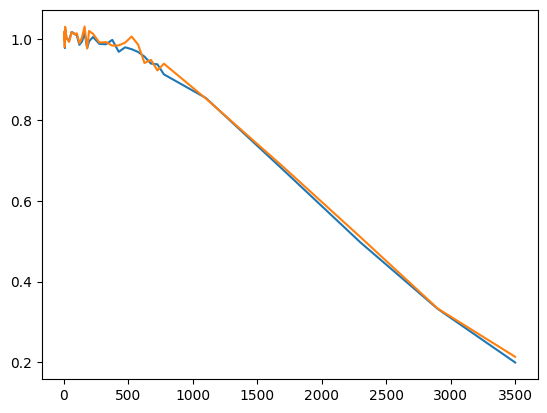

In [41]:
ell = np.arange(0, len(qe_cross_split[0])+1)
ACB = 7
ns = 0.85
cls_alpha = 10**(-ACB)*2*np.pi/(ell*(ell+1))**(ns)
cls_alpha[0] = 0

el, x = decorator(qe_cross_split[0])
#plt.loglog(el, x, color = "blue")
el, ii = decorator(qe_input[0])
#plt.plot(el, ii, color = "red")
frac = x/ii
plt.plot(el, frac)
#plt.loglog(hp.alm2cl(a), ls = "--")
#plt.plot(inputs[0], color = "black")
#plt.plot(cls_alpha, lw = 2, ls = "--")

el, x = decorator(qe_cross_0_split[0])
#plt.loglog(el, x, color = "green")
el, ii = decorator(qe_0_input[0])
#plt.plot(el, ii, color = "cyan")
frac = x/ii
plt.plot(el, frac)

In [49]:
ngg = np.loadtxt(f"n_gg_a_QE.txt")[:5001]
ngg_10 = np.loadtxt(f"ngg_a_itr_10.txt")[:5001]


ell = np.arange(0, 5001)
ACB = 7
ns = 1.
cls_alpha = 10**(-ACB)*2*np.pi/(ell*(ell+1))**(ns)
cls_alpha[0] = 0


WFth = cls_alpha/(cls_alpha+ngg)
WFth10 = cls_alpha/(cls_alpha+ngg_10)

/tmp/ipykernel_5711/408011360.py:8: RuntimeWarning: divide by zero encountered in divide
  cls_alpha = 10**(-ACB)*2*np.pi/(ell*(ell+1))**(ns)


/tmp/ipykernel_5711/2118175320.py:16: RuntimeWarning: invalid value encountered in divide
  WF = cross_split[0][itr]/inputs[0]


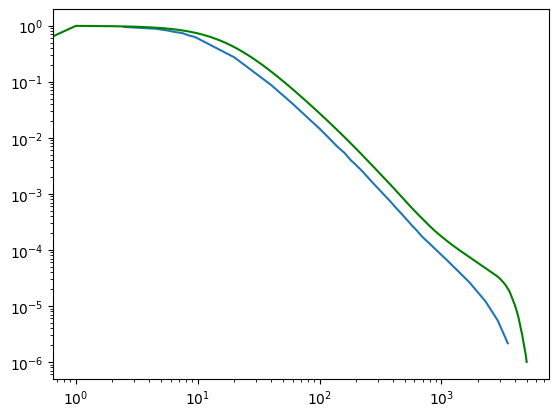

In [56]:
config_paths = ["official"]#, "official_a_disabled", "official_a_disabled_scale_dependent"]#,  "config_full_no_alpha_no_curl_lensing_cmb_s4"]
config_paths = [f"configs/{config}.yaml" for config in config_paths]

for j, config_path in enumerate(config_paths):
    selected, autoits, crossits, auto_input_its, _, _ = process_config_npy(config_path)

    autos = autoits.mean(axis = 0)
    crosses = crossits.mean(axis = 0)

    inputs = auto_input_its.mean(axis = 0)

    autos_split = np.split(autos, len(selected), axis = -1)
    cross_split = np.split(crosses, len(selected), axis = -1)

    for itr in [10]:
        WF = cross_split[0][itr]/inputs[0]
        #plt.loglog(WF, ls = "-" if j == 0 else "--")
        el, WF = decorator(WF)
        plt.loglog(el, WF, ls = "-" if j == 0 else "--")

        if itr == 0:
            plt.loglog(WFth, color = "red")
        else:
            plt.loglog(WFth10, color = "green")

In [25]:
config_paths = ["official_a_disabled", "official_so_a_disabled", "official", "alpha_after_lensing_sims", "config_full_alpha_disabled_lensing_cmb_s4_new_rotation", "config_full_alpha_disabled_lensing_cmb_s4_new_rotation_no_curl_est"]#,  "config_full_no_alpha_no_curl_lensing_cmb_s4"]


#config_paths = config_paths[1:]
config_paths = [f"configs/{config}.yaml" for config in config_paths]

socase = "so" in config_paths[0]

label = "so" if socase else "s4"
dir = "sodata/" if socase else ""
direc = "_so" if socase else ""

ngg = np.loadtxt(f"{dir}n_gg_a_QE.txt")[:5001]

ngg_10 = np.loadtxt(f"{dir}ngg_a_itr_10.txt")[:5001]

#n1_ap = np.loadtxt(f"{dir}n1_ap.txt")[:5001]
#ngg_unl = np.loadtxt(f"{dir}ngg_a_itr_unl.txt")[:5001]

In [26]:
"""plt.title(label+" Wiener filters")
plt.loglog(WFth, label = "WF QE")

plt.loglog(WFth10, label = "WF iter th")

i = 0
itr = -1
WF = cross_split[i][itr]/inputs[i]
plt.plot(WF)
el, WF = decorator(WF)
plt.plot(el, WF, label = "WF iter from cross")

plt.legend()"""

'plt.title(label+" Wiener filters")\nplt.loglog(WFth, label = "WF QE")\n\nplt.loglog(WFth10, label = "WF iter th")\n\ni = 0\nitr = -1\nWF = cross_split[i][itr]/inputs[i]\nplt.plot(WF)\nel, WF = decorator(WF)\nplt.plot(el, WF, label = "WF iter from cross")\n\nplt.legend()'

/tmp/ipykernel_31662/2706754959.py:32: RuntimeWarning: invalid value encountered in divide
  WF = cross_split[i][itr]/inputs[i]


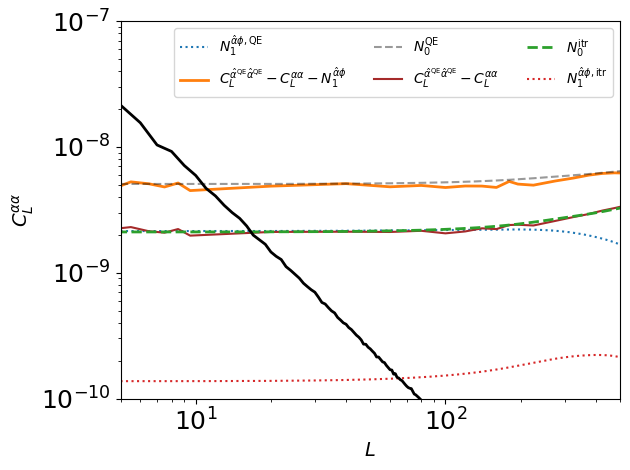

/tmp/ipykernel_31662/2706754959.py:32: RuntimeWarning: invalid value encountered in divide
  WF = cross_split[i][itr]/inputs[i]


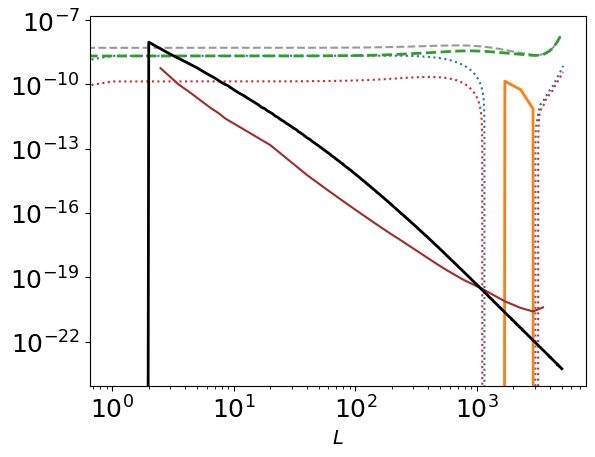

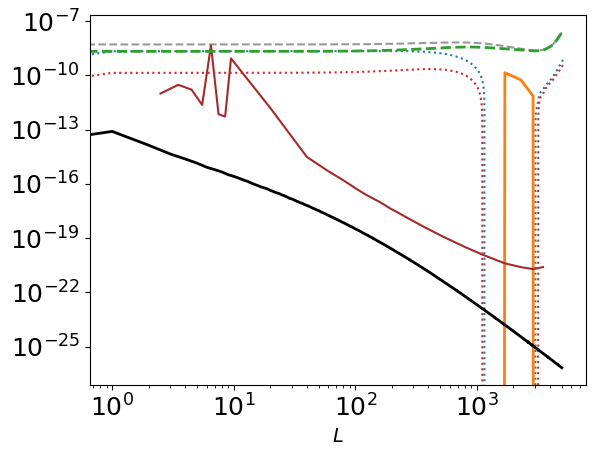

In [ ]:
selected = ['a', 'p', 'o']

invWFs = {}


for i, s in enumerate(selected):
    for j, config_path in enumerate(config_paths[:1]):
        selected, autoits, crossits, auto_input_its, _, _ = process_config_npy(config_path)

        autos = autoits.mean(axis = 0)
        crosses = crossits.mean(axis = 0)
        inputs = auto_input_its.mean(axis = 0)

        stdautos = autoits.std(axis = 0)

        autos_split = np.split(autos, len(selected), axis = -1)
        cross_split = np.split(crosses, len(selected), axis = -1)

        """plt.loglog(cross_split[0][0]*WFth**-1.)

        plt.loglog(cross_split[0][-1]*WFth10**-1.)

        plt.loglog(inputs[0])
        plt.show()"""

        WFth = inputs[0]/(ngg+inputs[0])
        WFth10 = inputs[0]/(ngg_10+inputs[0])


        for itr in [0, autos.shape[0]-1]:
    
            WF = cross_split[i][itr]/inputs[i]
            el, WF_ = decorator_WF(WF)
            import scipy.interpolate
            WFf = scipy.interpolate.interp1d(el, WF_, kind = "linear", fill_value = "extrapolate")
            ls = np.arange(100, 5001)
            WFinterp = WFf(ls)
            WF[100:] = WFinterp
            
            if itr == 0:
                WFQE = WF
            invWF = WF**-1.
            if j == 0:
                invWFs[s] = invWF
            #xx = autos_split[i][itr]*invWFs[s]**2.-inputs[i]


            if itr == 0:

                n1_ap = np.loadtxt(f"noise_biases{direc}/n1_ap_QE.txt")

                plt.loglog(n1_ap, label = r"$N_1^{\hat{\alpha}\phi, \mathrm{QE}}}$", ls = ":")

                xx = autos_split[i][itr]*WF**-2.-inputs[i]-n1_ap[:5001]

                #n1_aa = np.loadtxt(f"noise_biases{direc}/n1_aa_QE.txt")
                #plt.loglog(n1_aa, ls = "--")
                el, x = decorator(xx)
                
                #plt.plot(autos_split[i][itr]*WFth**-2.-nggs["a"][:5001]-inputs[i], color = "green")
               # plt.plot(autos_split[i][itr]*WFth**-2., color = "green")
                plt.plot(el, x, lw = 2, label = r"$C_L^{\hat{\alpha}^{\mathrm{QE}}\hat{\alpha}^{\mathrm{QE}}}-C_L^{\alpha\alpha}-N_1^{\hat{\alpha}\phi}$")
                
                #el, xy = decorator(autos_split[i][itr]*invWFs[s]**2.)
                #el, xy = decorator(autos_split[i][itr]*WFth**-2.)
                #plt.plot(el, xy, label = "WF normalized")
                #np.savetxt("x.txt", np.c_[el, xy])

                
                #el, xy = decorator(qe_alpha)
                #plt.plot(el, xy, ls = "--", label = "QE normalized")

            else:
                el, x = decorator(autos_split[i][itr]*WF**-2.-inputs[i])
                plt.plot(el, x, color = "brown", label = r"$C_L^{\hat{\alpha}^{\mathrm{QE}}\hat{\alpha}^{\mathrm{QE}}}-C_L^{\alpha\alpha}$")
                #el, x = decorator(autos_split[i][itr]*WF**-2.)
                #plt.plot(el, x, color = "red", ls = "--")
                plt.plot(ngg_10, lw = 2, label = r"$N_0^{\mathrm{itr}}$", ls = "--")

                n1_ap = np.loadtxt(f"noise_biases{direc}/n1_ap_itr_10.txt")
                plt.loglog(n1_ap, label = r"$N_1^{\hat{\alpha}\phi, \mathrm{itr}}}$", ls = ":")

                #n1_aa = np.loadtxt(f"noise_biases{direc}/n1_aa_itr_10.txt")
                #plt.loglog(n1_aa, ls = ":")

                
            #plt.loglog(el, x, lw = 2, label= config_path)

            if itr == 0:
                xx = 0
                #ff = np.split(fs[i], 3)[xx]
                #ff1000 = np.split(fs1000[i], 3)[xx]
                #np.savetxt("corr.txt", invWFs[s])
                #xx = ffmean[:5001]*invWFs[s]**2-inputs[i]
                #el, x = decorator(xx)
                #plt.loglog(el, x, lxs = "--")

                xx = autoits[i][0][:5001]*invWFs[s]**2#-inputs[i]
                el, x = decorator(xx)
                #plt.loglog(el, x, ls = "--", color = "black")
                #plt.plot(n1_ap, color = "cyan")
                
                plt.plot(ngg, color = "black", alpha = 0.4, label = r"$N_0^{\mathrm{QE}}$", ls = "--")
                #plt.plot(n0_bb, ls = "--")

                #xx = ff1000means[0][:5001]*WFth**-2.
                #el, x = decorator(xx)
                #np.savetxt("xrand.txt", np.c_[el, x])
                #plt.loglog(el, x, ls = ":")
                #plt.loglog(n1_bb**-1.)
            else:
                #xx = ff1000means[1][:5001]*invWF**2.
                #el, x = decorator(xx)
                #plt.loglog(el, x, ls = ":")
                #ngg = np.loadtxt("noise_biases/ngg_a_QE.txt")
                pass



        plt.plot(inputs[i], color = "black", lw = 2)#, label = r"$C_L^{\alpha\alpha}$")
        #plt.plot(nggs[s], lw = 2)
        #plt.plot(n0_bb)
        #plt.title(s)
        #print(a)
        #plt.xlim(5, 2000)
        #plt.savefig("")
        plt.yticks(fontsize = 18)
        
        plt.xticks(fontsize = 18)
        plt.xlabel(r"$L$", fontsize = 14)
    if s == "a":
        plt.ylabel(r"$C_L^{\alpha\alpha}$", fontsize = 14)
        if socase:
            #plt.ylim(1e-8, 5e-7)
            pass
        else:
            pass
        plt.ylim(1e-10, 1e-7)
        plt.tight_layout()
        plt.xscale("log")
        plt.yscale("log")
        plt.xlim(5, 500)
        plt.legend(ncol = 3, fontsize = 10)
        #plt.savefig(f"/users/odarwish/JointCMBiterative/figures/examples/alpha_improvements_{label}.pdf", dpi = 300)
    plt.show()

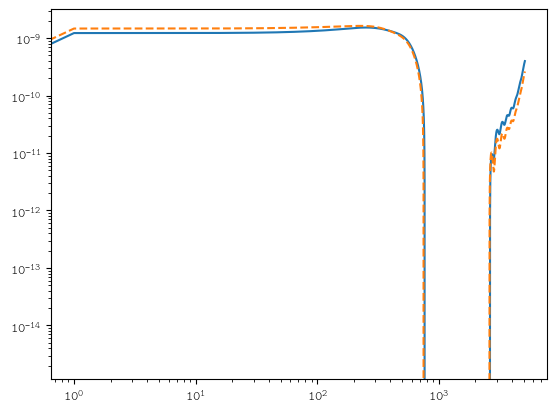

In [52]:
n1_ap = np.loadtxt(f"noise_biases{direc}/n1_ap_itr_10.txt")
plt.loglog(n1_ap)
n1_ap = np.loadtxt(f"noise_biases{direc}/n1_ap_QE.txt")
plt.loglog(n1_ap/2, ls = "--")

In [29]:
cross_phi = {0: {0: [], 15: []}, 1: {0: [], 15: []}}

def plot_configs_with_class(config_paths, subset_selected, itrs, outname):
    config_data = [process_config_npy(config_path) for config_path in config_paths]

    N_configs = len(config_paths)
    rows = len(subset_selected)
    cols = N_configs

    names_fields = {"p": r"$\phi$", "o": r"$\omega$", "f": r"$\tau$", "a": r"$\alpha$"}

    # Initialize CMBLensingPlot
    plot = CMBLensingPlot(rows=rows, cols=cols, figsize=(10, 6), sharex=True, sharey = False, outdir = "../plots/")

    for j, (selected, autoits, crossits, auto_input_its, crossits_down, auto_input_down_its) in enumerate(config_data):  # Iterate over configurations
            
            autos = autoits.mean(axis = 0)
            crosses = crossits.mean(axis = 0)
            inputs = auto_input_its.mean(axis = 0)

            crosses_down = crossits_down.mean(axis = 0)
            inputs_down = auto_input_down_its.mean(axis = 0)

            stdautos = autoits.std(axis = 0)

            autos_split = np.split(autos, len(selected), axis = -1)
            cross_split = np.split(crosses, len(selected), axis = -1)

            cross_down_split = np.split(crosses_down, len(selected), axis = -1)

            for i, k in enumerate(subset_selected):  # Iterate over estimators

                original_idx = selected.index(k)
            
                for idx, itr in enumerate(itrs):  # Iterate over iterations
                    
                    el, cross = cross_corr_coeff_from_cl(autos_split[original_idx][itr], inputs[original_idx], cross_split[original_idx][itr], plot=False)

                    if k=="p":
                         cross_phi[j][itr] = autos_split[original_idx][itr]

                    el, cross_down = cross_corr_coeff_from_cl(autos_split[original_idx][itr], inputs_down[original_idx], cross_down_split[original_idx][itr], plot=False)
                    plot.add_curve(el, cross, label=f"itr {itr}", row=i, col=j, linewidth = 1.5)
                    plot.add_curve(el, cross_down, label=f"itr {itr}", row=i, col=j, linewidth = 1.5, linestyle="--")

                plot.set_labels(xlabel=r"$L$", ylabel=r"$\rho_L$" + f"({names_fields[k]})", row=i, col=j)
                plot.set_xlim(xmin = 5, xmax = 1000, row = i, col = j)

                plot.set_scale(xscale="log", row=i, col=j)
                """if k == "a":
                     plot.set_ylim(row = i, col = j, ymin = 0, ymax = 0.6)
                elif k == "o":
                    plot.set_ylim(row = i, col = j, ymin = 0, ymax = 0.3)"""
                if i == 0:
                    plot.set_title(k, row=i, col=j)
                    if j == 0:
                        plot.set_legend(row=i, col=j, fontsize = 10)

    #plot.save_plot(outname, dpi=300)
    plot.show_plot()

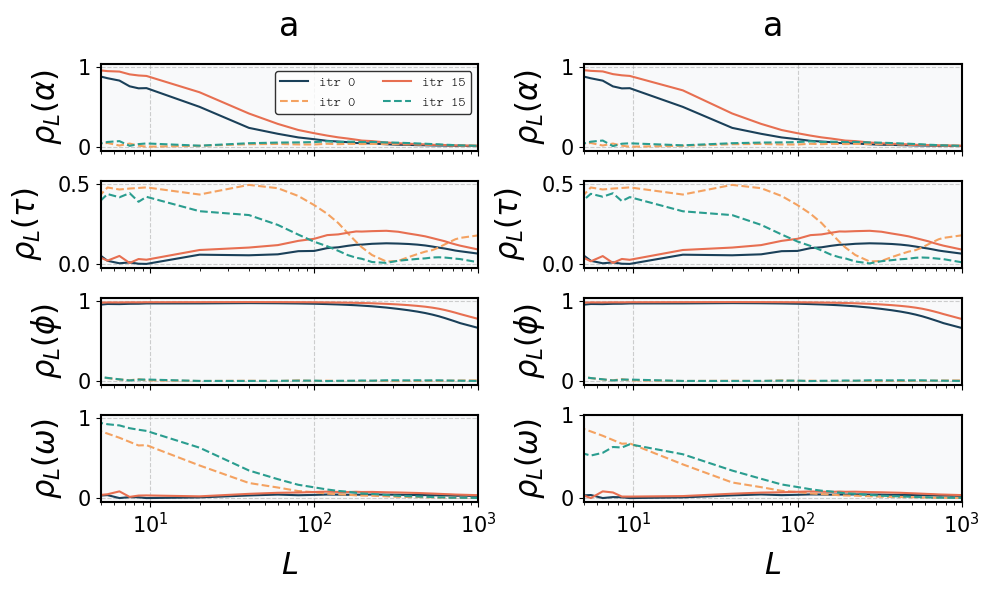

In [30]:
config_paths = ["official_multiple_disabled",  "official_multiple", "official_deep_multiple", "official_multiple", "official_multiple_disabled", "official_so_a_disabled", "alpha_after_lensing_sims", "config_full_alpha_disabled_lensing_cmb_s4_new_rotation", "config_full_alpha_disabled_lensing_cmb_s4_new_rotation_no_curl_est"]#,  "config_full_no_alpha_no_curl_lensing_cmb_s4"]
config_paths = [f"configs/{config}.yaml" for config in config_paths]
config_paths = config_paths[:2]

subset_selected = ["a", "f", "p", "o"]
itrs = [0, 15]#, 15]
outname = ""
plot_configs_with_class(config_paths, subset_selected, itrs, outname)

In [31]:
cross_phi

{0: {0: array([0.00000000e+00, 0.00000000e+00, 7.87969107e-09, ...,
         1.61770824e-26, 1.61511759e-26, 1.61331630e-26]),
  15: array([0.00000000e+00, 0.00000000e+00, 7.75256360e-09, ...,
         1.54413683e-26, 1.54466070e-26, 1.54153783e-26])},
 1: {0: array([0.00000000e+00, 0.00000000e+00, 7.87969108e-09, ...,
         1.61770824e-26, 1.61511759e-26, 1.61331630e-26]),
  15: array([0.00000000e+00, 0.00000000e+00, 6.51813693e-09, ...,
         1.54412751e-26, 1.54463366e-26, 1.54153951e-26])}}

/tmp/ipykernel_26833/3116759026.py:1: RuntimeWarning: invalid value encountered in divide
  plt.plot(cross_phi[0][15]/cross_phi[1][15])


(0.95, 1.05)

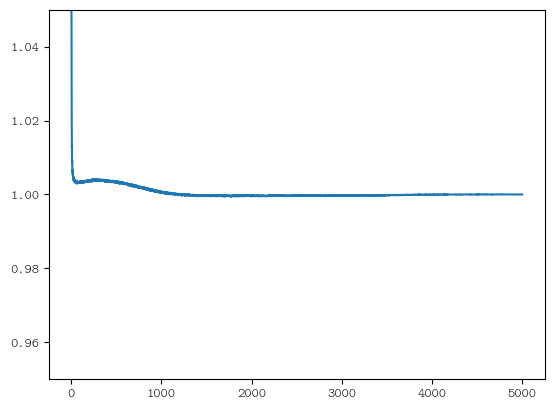

In [35]:
plt.plot(cross_phi[0][15]/cross_phi[1][15])
plt.ylim(0.95, 1.05)